# Aprendizaje Automático: Trabajo Práctico 1 

* Alumnxs: Facundo Garcia, Trinidad Borrell
* Octubre 2024



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pointbiserialr
from collections import Counter
from tqdm import tqdm
import os
import pickle


COLOR = "black"
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["figure.dpi"] = 50
plt.rcParams["figure.figsize"] = (28, 18)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams["figure.dpi"] = 50
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.fontsize"] = 20
plt.rcParams['legend.title_fontsize'] = 40  
plt.rcParams["axes.titlesize"] = 40
plt.rcParams["axes.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20

plt.rcParams["axes.grid"] = True

plt.rcParams["text.color"] = COLOR
plt.rcParams["text.color"] = COLOR
plt.rcParams["axes.labelcolor"] = COLOR
plt.rcParams["xtick.color"] = COLOR
plt.rcParams["ytick.color"] = COLOR
plt.rcParams["grid.color"] = COLOR
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

Cargamos los datos:

In [2]:
df = pd.read_csv("data.csv")
display(df.head(5))
print(df.shape)

,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
0,-6.774862,0.732090,0.500918,0.944929,-0.602723,1.032872,6.064671,-1.569083,-0.433074,-0.411138,...,3.875406,5.014296,0.302964,-0.719671,1.771007,-38.327154,-1.016544,-0.910132,-4.412012,0
1,3.857655,-0.612246,0.618588,0.459552,0.784440,-0.468198,0.651061,-4.741020,-0.552092,-5.488178,...,-3.830493,-3.467904,0.938938,-2.063109,0.179054,-11.194070,-5.197824,-0.286773,21.186963,1
2,-4.350896,0.654858,-0.424538,0.400425,-0.695568,0.954559,0.381870,1.490369,-1.097865,8.438625,...,2.430782,3.176884,1.521718,1.066505,-1.413488,10.341004,-4.757295,1.043693,-13.073736,0
3,-0.661896,-0.047801,0.025763,0.396485,-0.789812,-1.025823,2.003485,-2.794396,0.416429,3.011011,...,-3.220567,6.810913,1.641394,-0.715173,-0.041199,16.963959,-5.634772,1.736776,15.345755,0
4,1.596179,2.670130,0.961231,-0.337469,0.422516,-1.507684,3.563408,0.461990,-0.298087,-1.129244,...,0.721628,-1.546083,0.020279,1.458865,0.887693,15.078228,-3.548321,1.544351,6.419401,0


(500, 201)


## Ejercicio 1

Tenemos solamente 500 instancias para 200 clases. Primero analicemos la correlación entre las features con la variable objetivo, para entender si hay alguna feature con mayor poder predictivo que otras.

(0.0, 200.0)

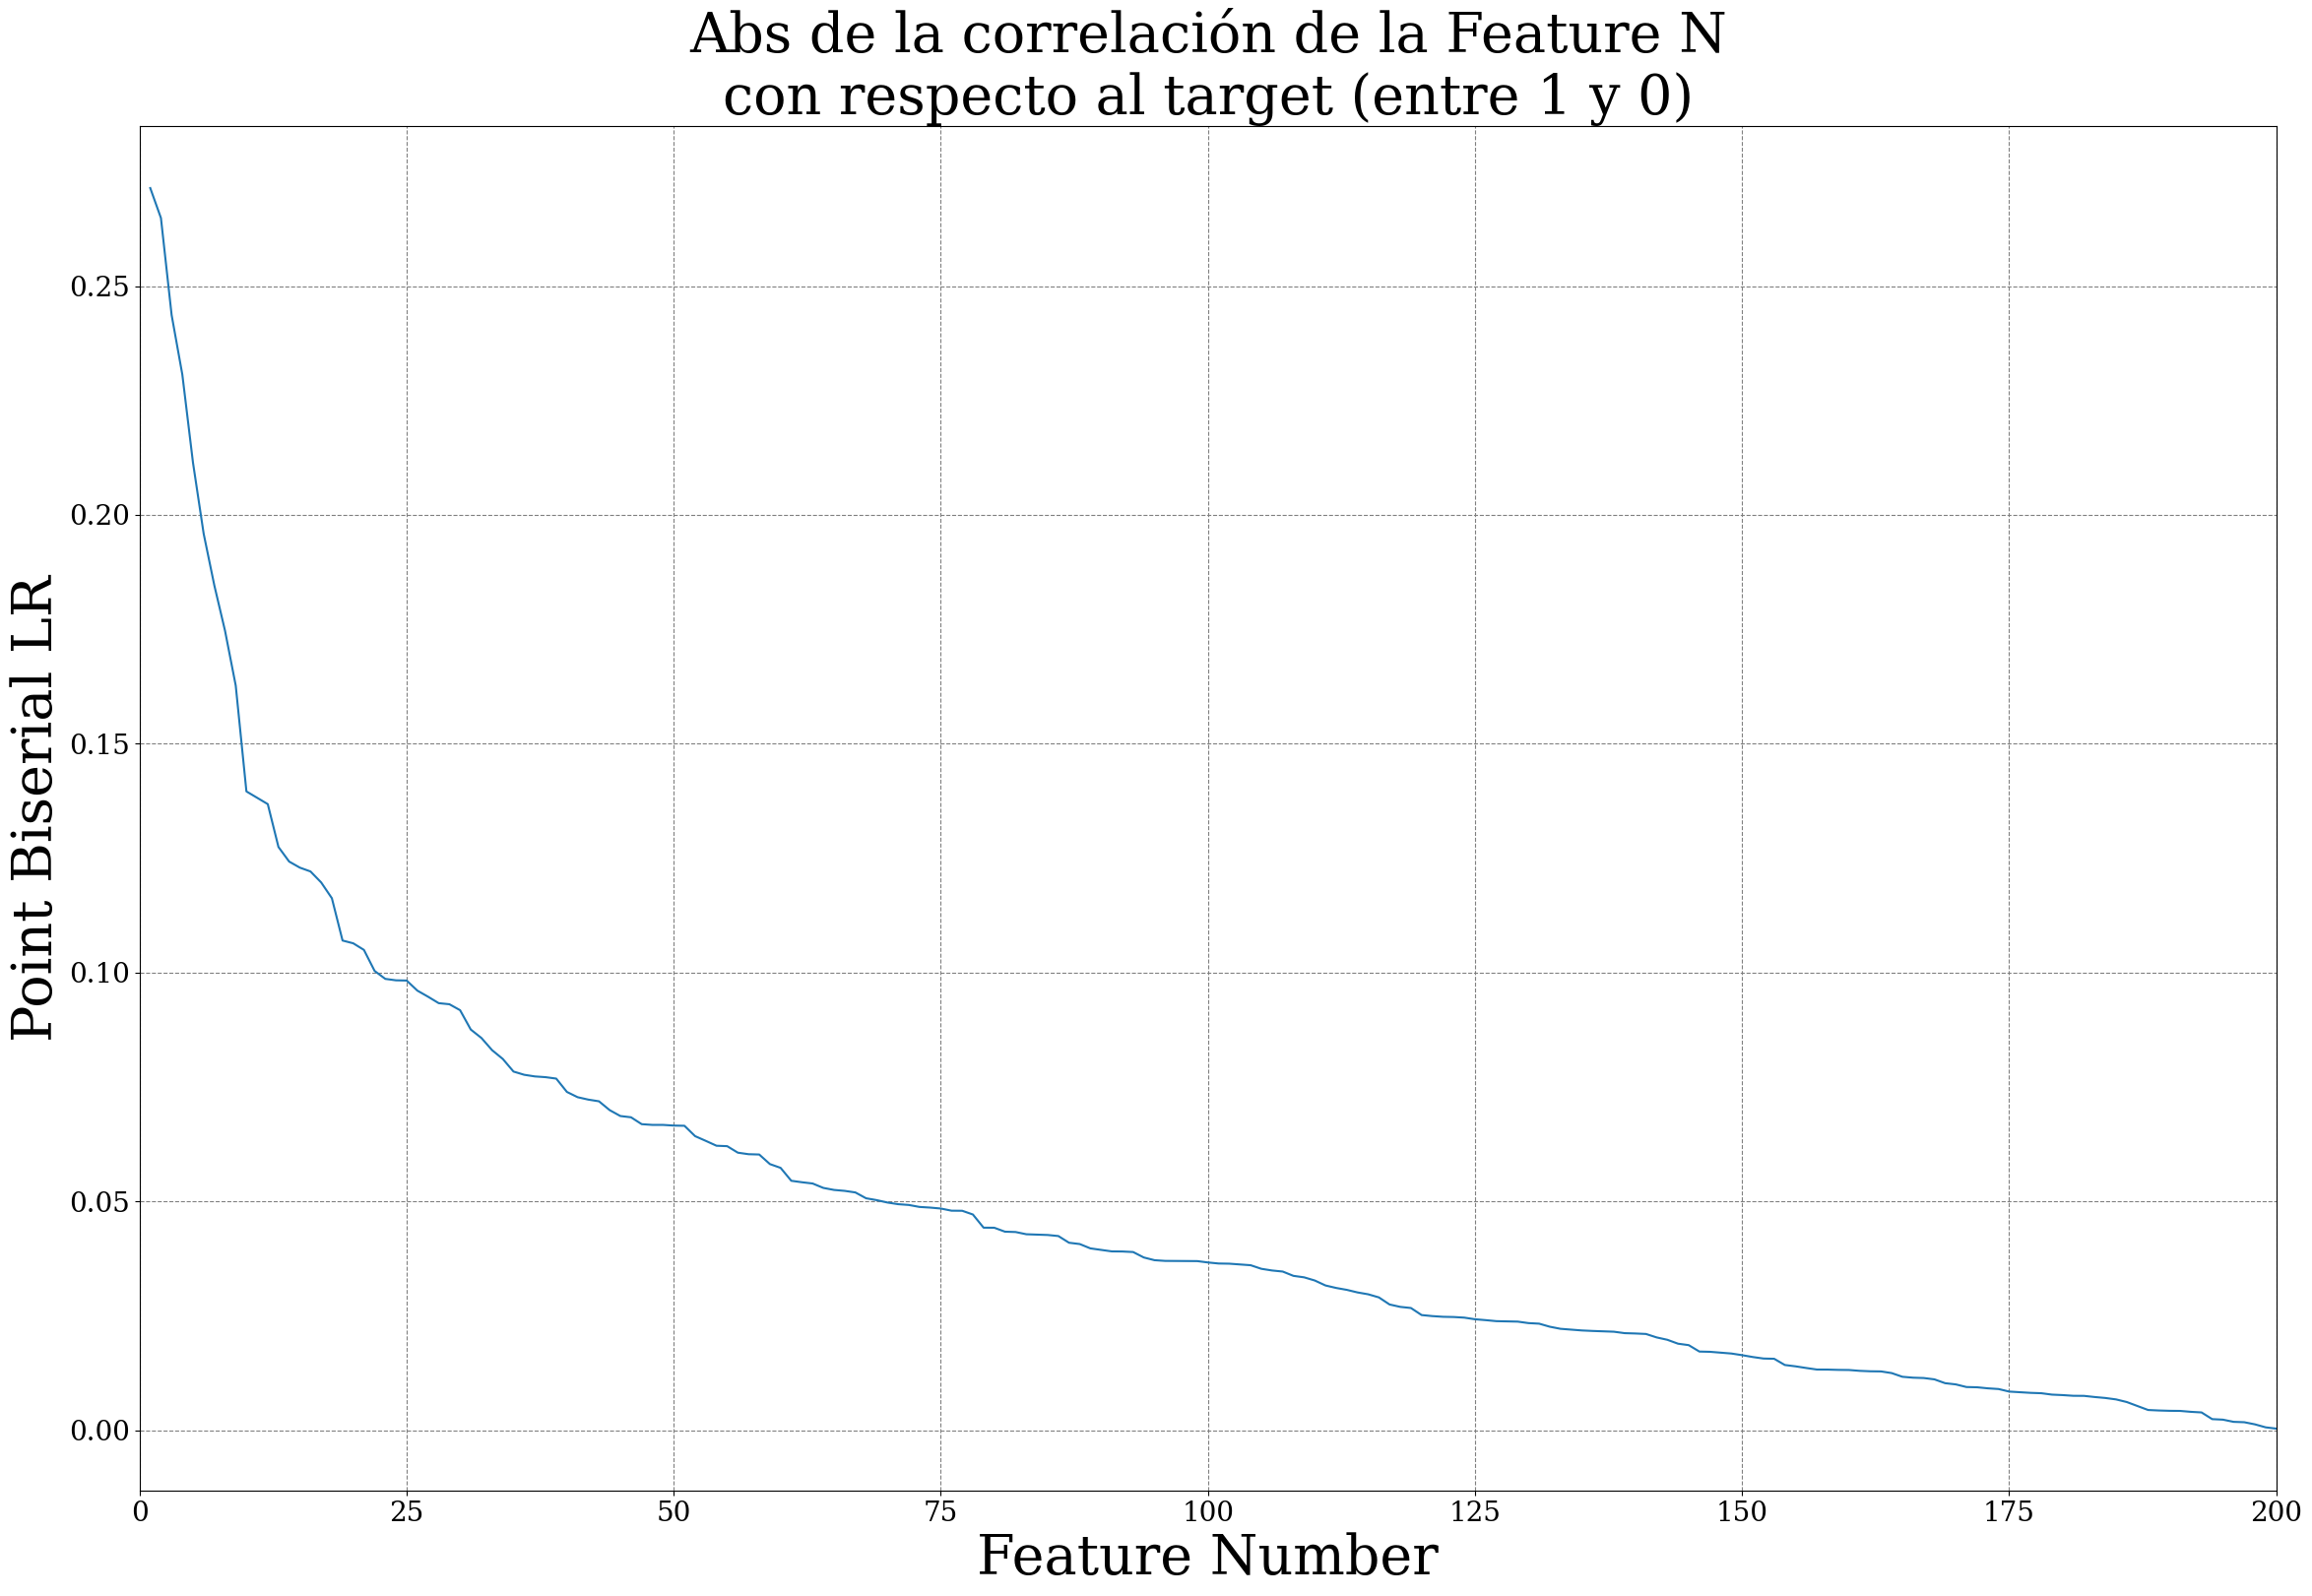

In [3]:
scores = [(c, abs(pointbiserialr(df["target"], df[c]).statistic)) for c in df.columns if c != "target"]
scores = sorted(scores, key=lambda x: x[1], reverse=True)#[:15]
scores = dict(scores)

plt.plot(range(1, len(scores) + 1), scores.values())
plt.xlabel("Feature Number")
plt.ylabel("Point Biserial LR")
plt.grid(ls="--", color="gray")
plt.title("Abs de la correlación de la Feature N\ncon respecto al target (entre 1 y 0)")
plt.xlim(0, 200)

Hay una gran cantidad de Features que no tienen importancia. Lo primero que pensamos en que si nos quedamos con las primeras 25 features por ejemplo (las que tienen hasta 0.1 de correlación) podríamos armar un modelo más simple y con menos posibilidades de overfitting. Igualmente continuaremos usando el dataset completo.


Tambien veamos la cantidad de instancias positivas y negativas

Cociente entre buen pronostico y mal pronostico: 0.34408602150537637


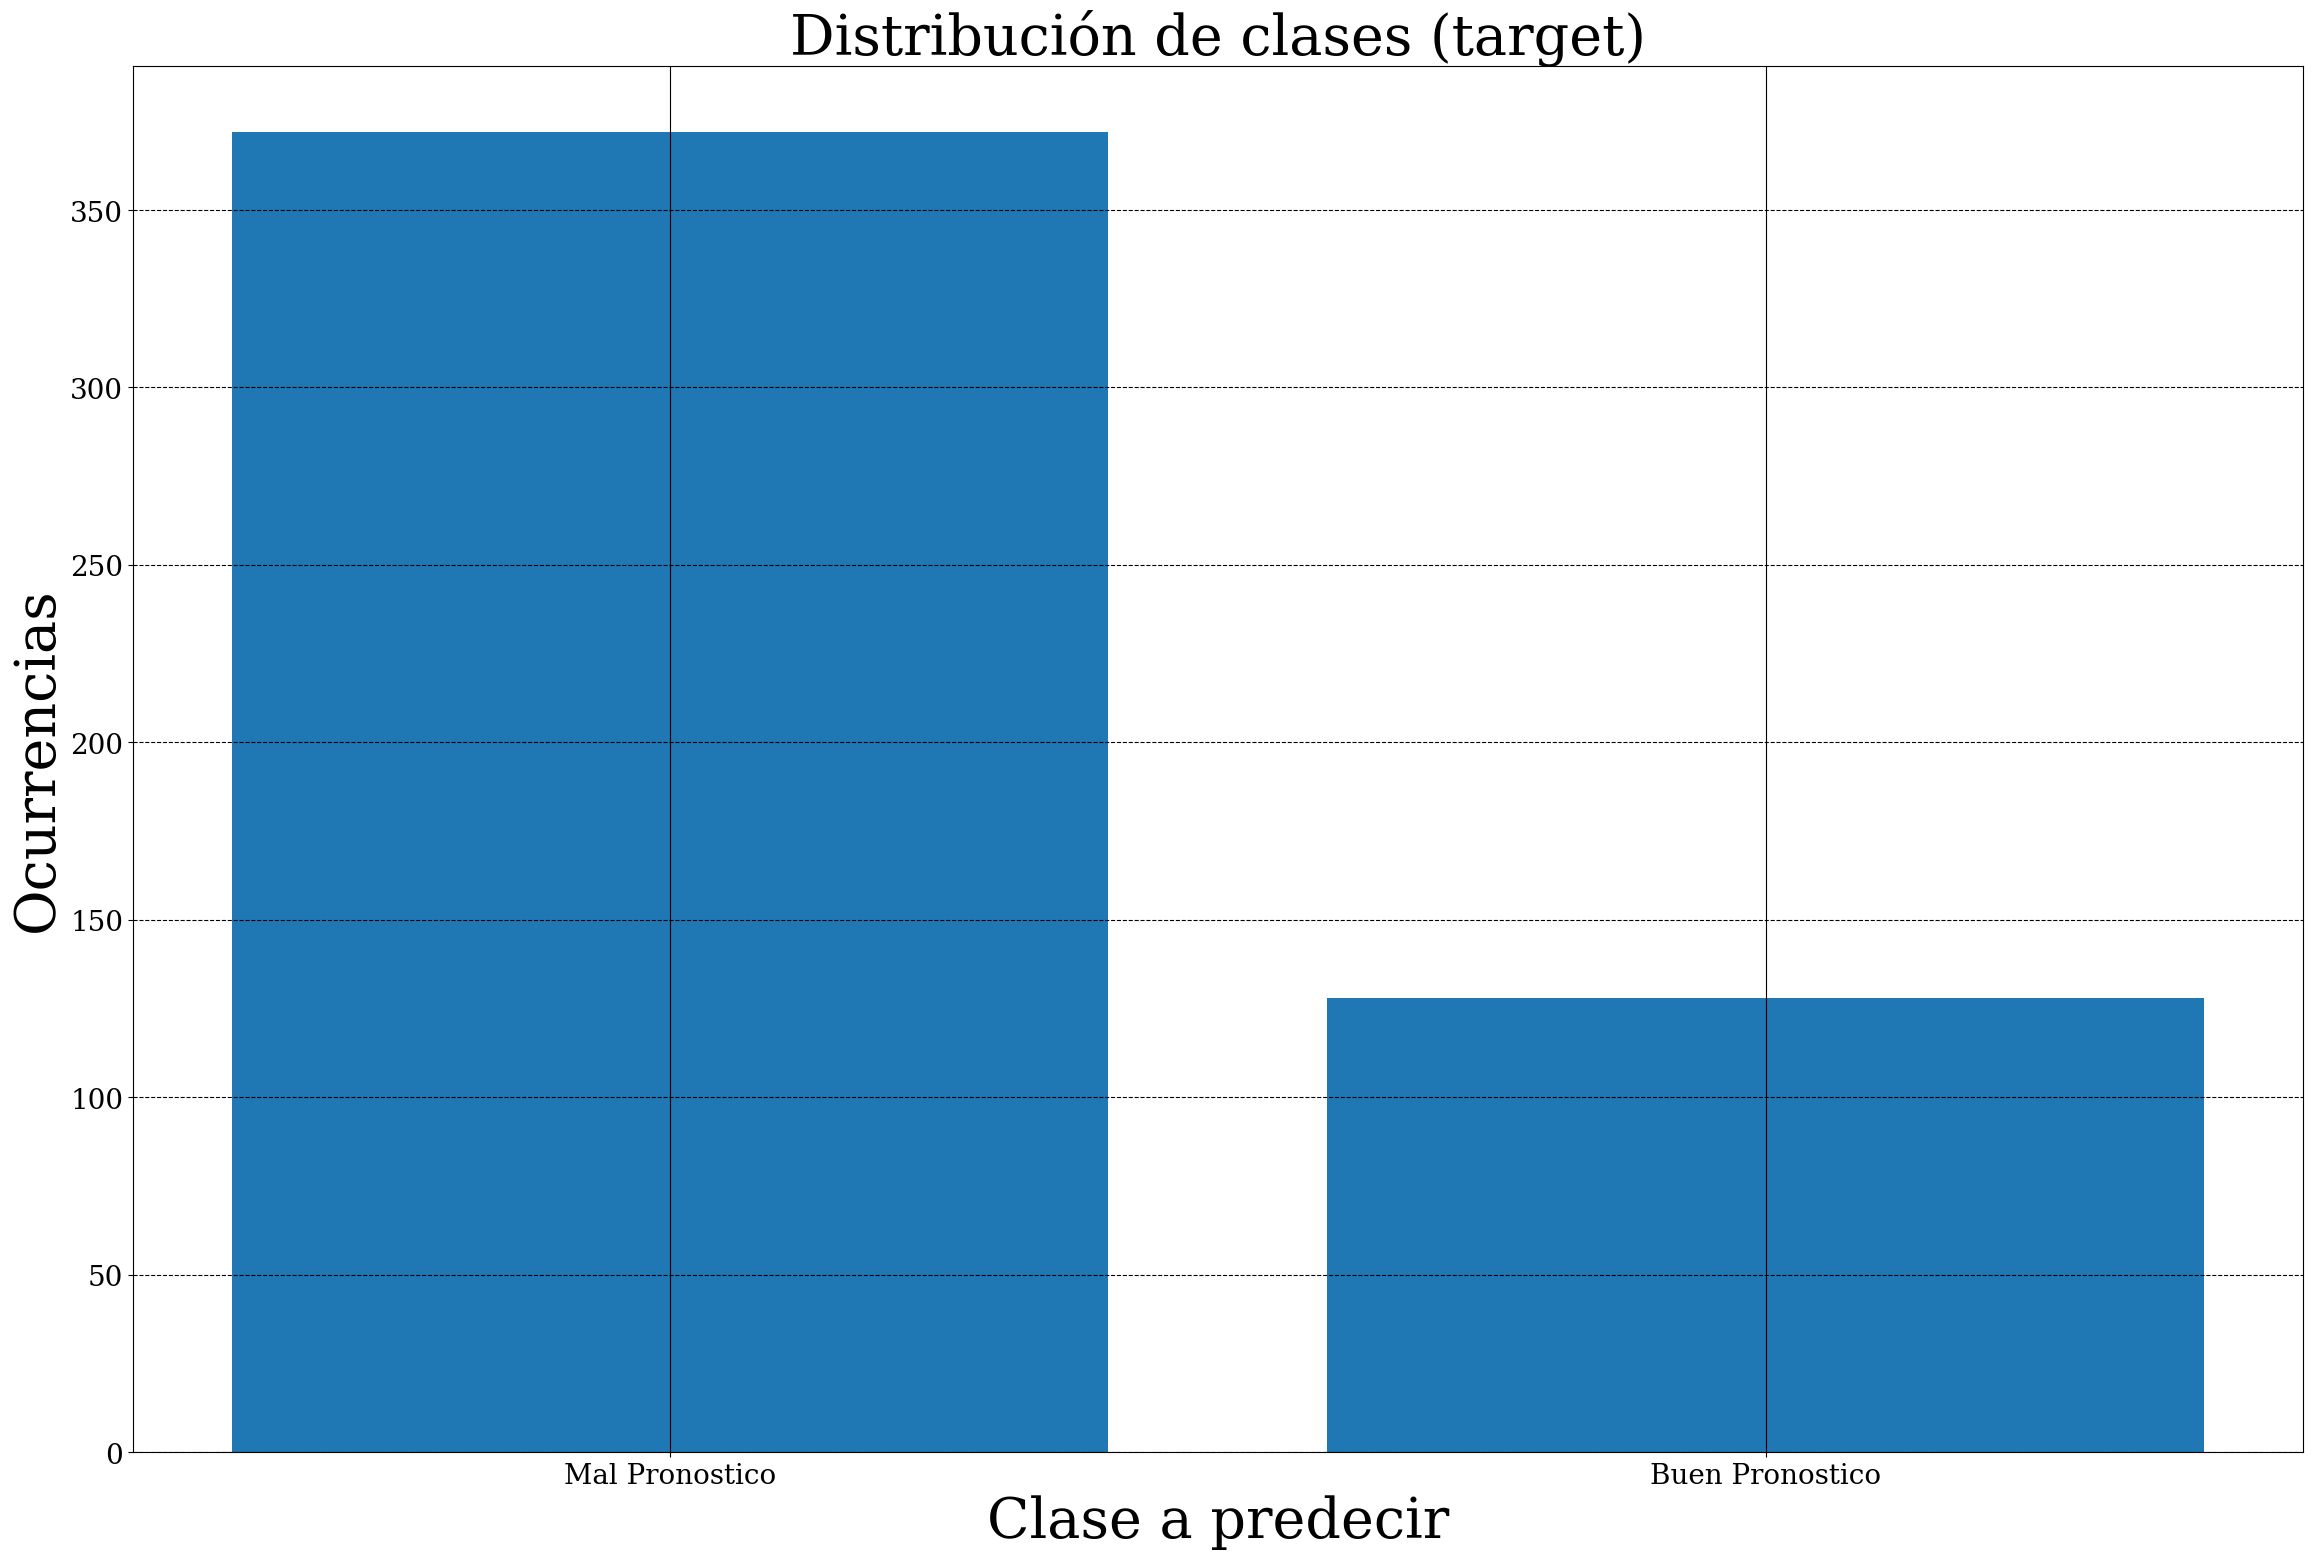

In [4]:
count_target = df.groupby("target")[df.columns[0]].count().to_dict()

plt.bar(count_target.keys(), count_target.values())
plt.xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
plt.ylabel("Ocurrencias")
plt.xlabel("Clase a predecir")
plt.grid(ls="--", axis="y")
plt.title("Distribución de clases (target)")

print(f'Cociente entre buen pronostico y mal pronostico: {count_target[1] / count_target[0]}')


Hay muchas mas instancias de la clase negativa que de la positiva, asi que hay que tener cuidado con eso a la hora de splittear (Hagamos un Random Sampling y chequeamos que tenga la misma distribución)

Otra cosa a tener en cuenta es que las variables están en distintas escalas (lo que afectará a algunos modelos)

In [5]:
df.describe()

,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-1.268970,0.044717,-0.037722,-0.113227,-0.046174,0.035109,0.183450,0.208851,0.042300,0.403542,...,-0.202378,-0.678978,0.044861,-0.008461,0.016833,0.742573,-0.497446,0.019266,-1.898646,0.256000
std,3.694494,0.947384,0.992520,1.045601,0.993927,1.053208,3.621348,3.824501,1.006565,3.527249,...,4.000686,3.511561,0.969914,0.987877,1.024802,13.496877,3.712092,0.970155,14.283931,0.436859
min,-12.087308,-2.529640,-3.865375,-4.586009,-3.065430,-3.385657,-10.452672,-11.179309,-2.598492,-10.489331,...,-13.919046,-13.270290,-3.441459,-3.708474,-3.844963,-41.565765,-10.335791,-2.778557,-48.944618,0.000000
25%,-3.853422,-0.613832,-0.674491,-0.845420,-0.727444,-0.698266,-2.234892,-2.335851,-0.612606,-1.848908,...,-2.834028,-3.129927,-0.595462,-0.693053,-0.661040,-8.567626,-2.641716,-0.639349,-12.791670,0.000000
50%,-1.159596,0.050974,-0.027905,-0.081188,-0.040581,0.050262,0.030444,0.007255,0.010516,0.333739,...,-0.155463,-0.518638,0.105221,-0.079414,0.045216,0.387785,-0.555591,0.027278,-2.100624,0.000000
75%,1.199991,0.622812,0.643218,0.538143,0.596633,0.740309,2.715722,2.996571,0.696505,2.880368,...,2.608309,1.745693,0.691559,0.721603,0.644195,9.570284,2.067777,0.695792,8.285581,1.000000
max,8.385931,2.918230,3.232409,2.824889,2.919894,3.063420,11.721612,12.726855,3.482503,9.418215,...,9.906167,8.062074,4.038584,3.625672,3.577172,39.923532,11.661381,2.769072,36.886538,1.000000


Probemos a hacer un random sample y chequear que la relación es la misma:

# Clase 1 / # Clase 0 en Train: 0.32
# Clase 1 / # Clase 0 en Test: 0.43


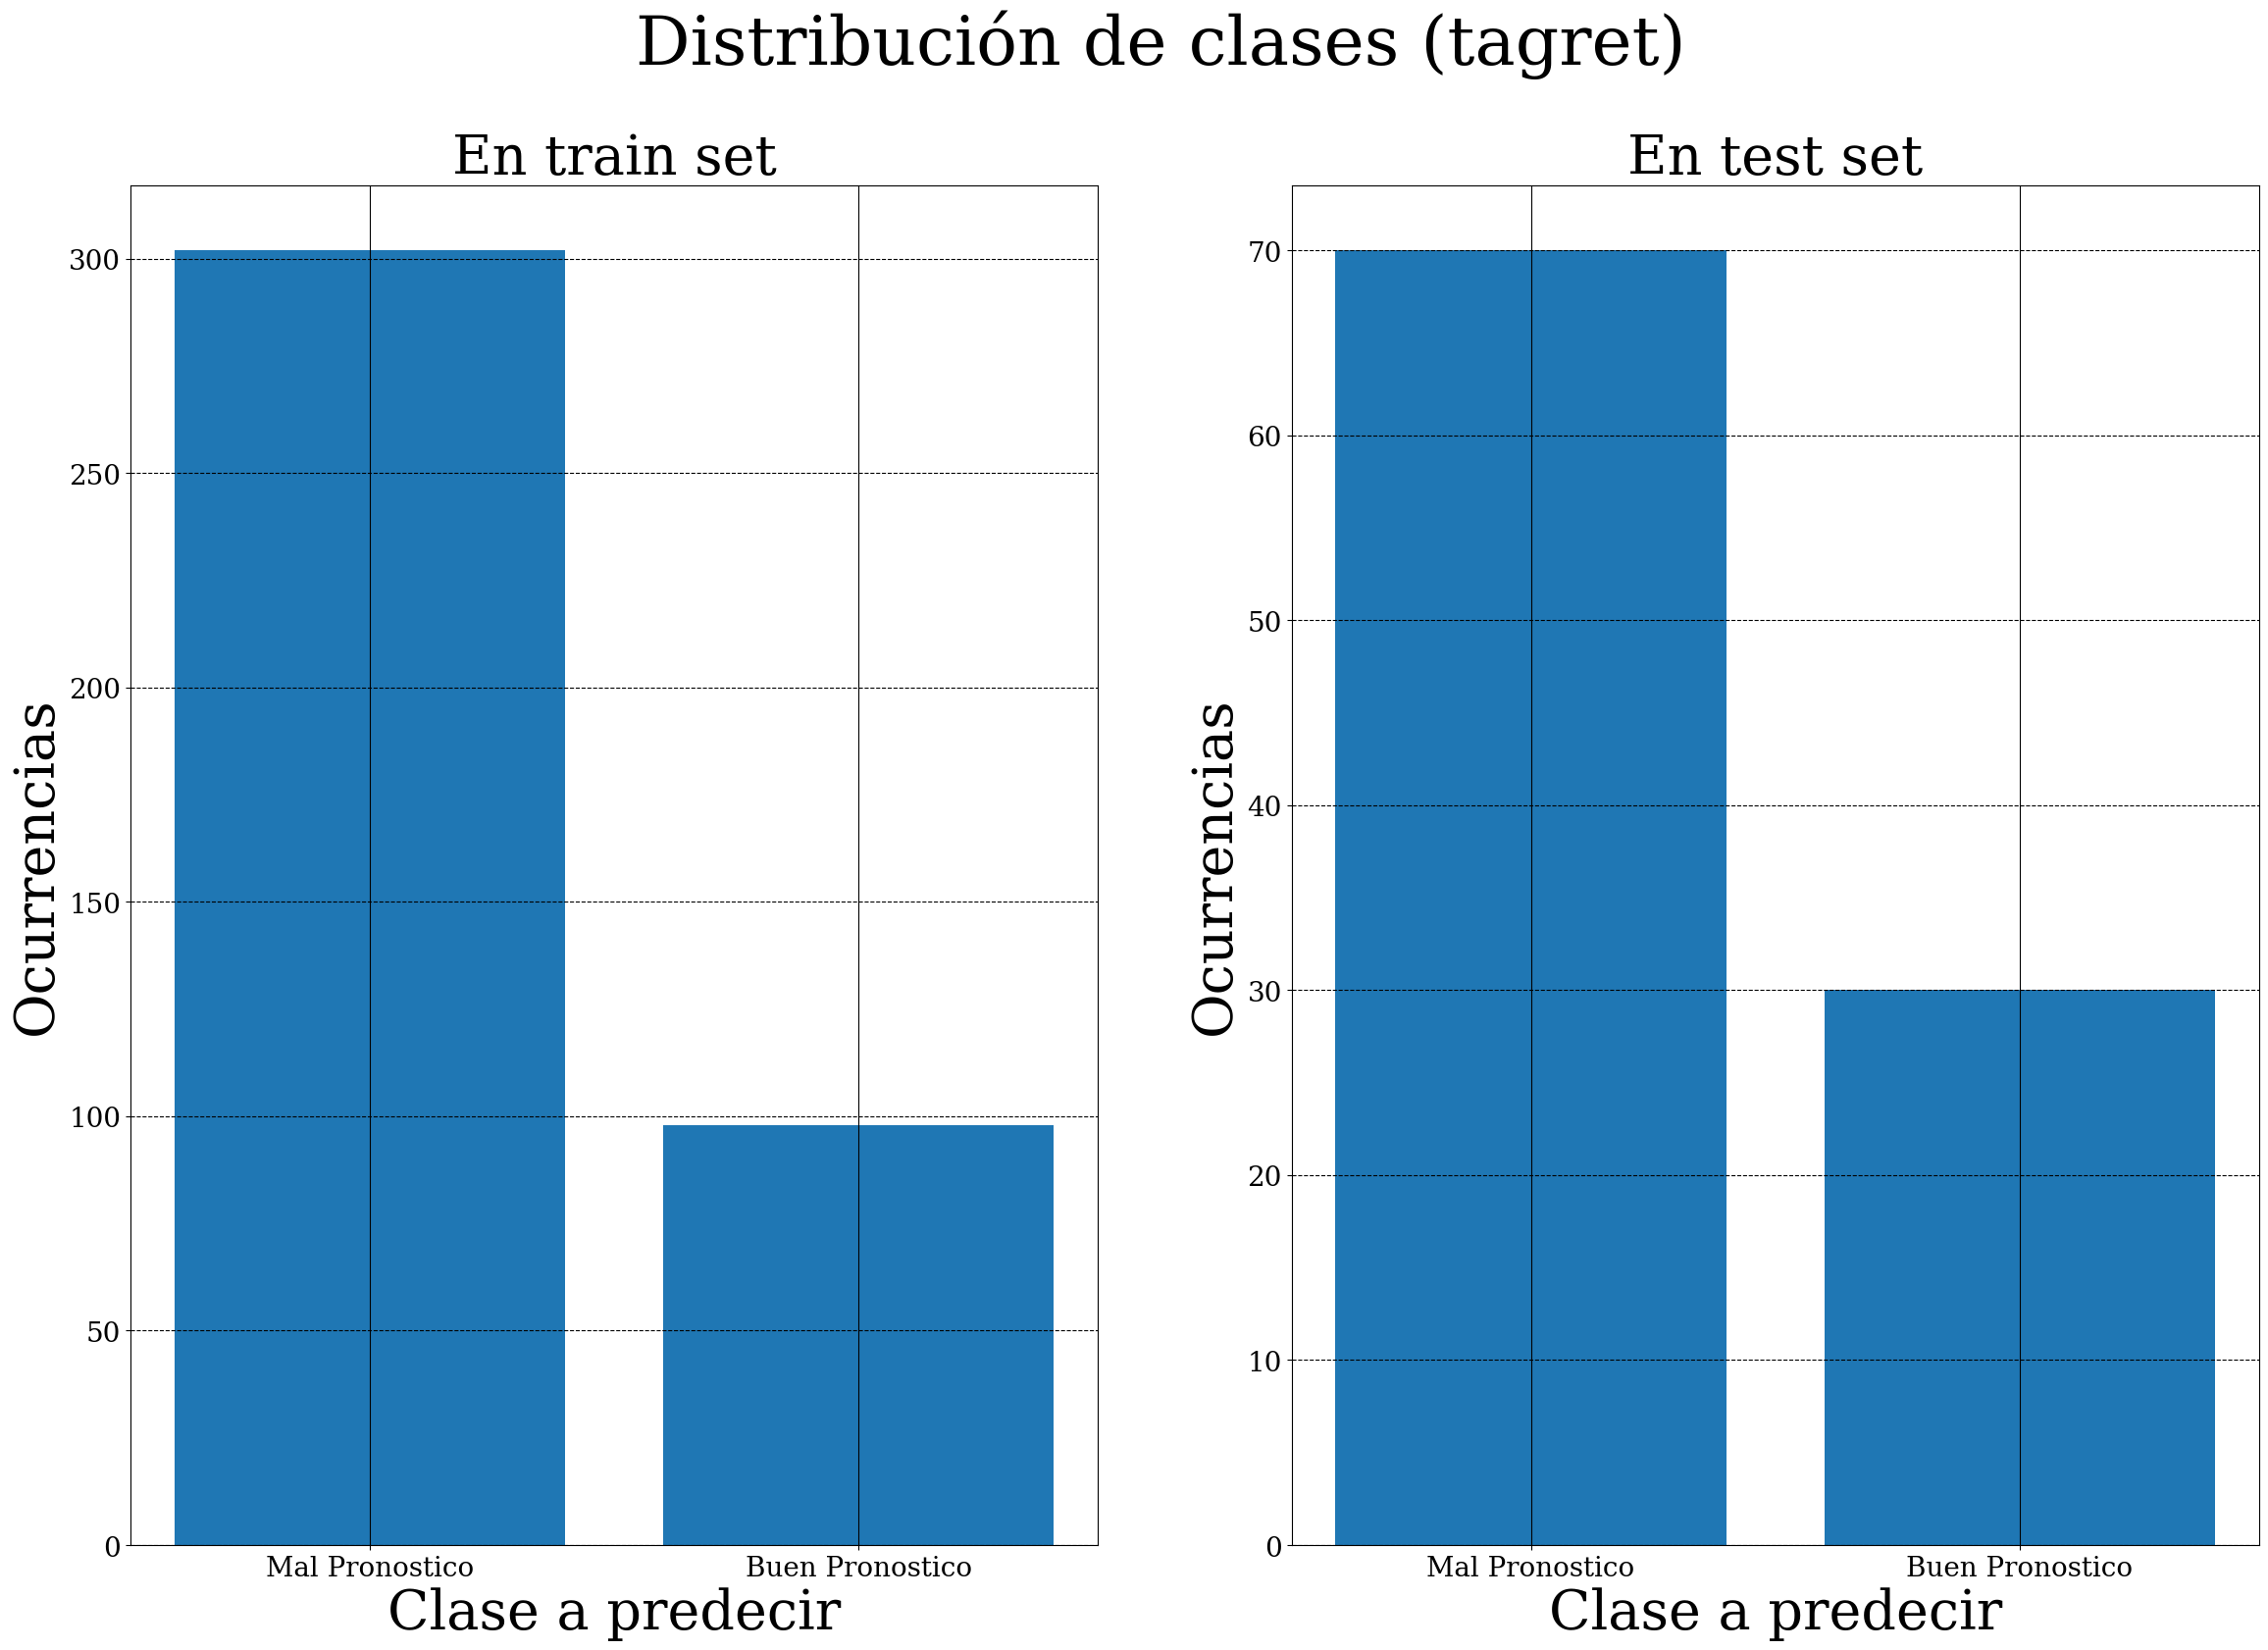

In [6]:
train_frac = 0.8

train_set = df.sample(frac=train_frac, random_state=44)
test_set = df.drop(train_set.index)

fig, ax = plt.subplots(1, 2)

plt.suptitle('Distribución de clases (tagret)', size = 50)

count_target_train = train_set.groupby("target")[train_set.columns[0]].count().to_dict()

print("# Clase 1 / # Clase 0 en Train:", round(count_target_train[1] / count_target_train[0], 2))

ax[0].bar(count_target.keys(), count_target_train.values())
ax[0].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[0].set_ylabel("Ocurrencias")
ax[0].set_xlabel("Clase a predecir")
ax[0].grid(ls="--", axis="y")
ax[0].set_title("En train set")

count_target_test = test_set.groupby("target")[test_set.columns[0]].count().to_dict()

print("# Clase 1 / # Clase 0 en Test:", round(count_target_test[1] / count_target_test[0], 2))

ax[1].bar(count_target.keys(), count_target_test.values())
ax[1].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[1].set_ylabel("Ocurrencias")
ax[1].set_xlabel("Clase a predecir")
ax[1].grid(ls="--", axis="y")
ax[1].set_title("En test set")

plt.show()

Hagamos una selección a mano para que la proporción de clases positivas y negativas sea la misma:

In [7]:
def stratified_sampling(
        df: pd.DataFrame,
        train_frac: float = 0.8
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Obtener el set de entrenamiento y testeo asegurandose
    que se respeta la proporción entre positivos y negativos
    tanto en el set de entrenamiento como en testeo.
    """

    # Contamos cuantas instancias de cada tipo hay
    count_target = df.groupby("target")[train_set.columns[0]].count().to_dict()

    # Calculamos cuantas instancias de entrenamiento vamos a usar
    count_target_train = {0: count_target[0] * train_frac,
                          1: count_target[1] * train_frac}

    # Nos quedamos con los N elementos calculados por cada clase
    pos_train_df = df[df["target"] == 1].sample(n=int(count_target_train[1]), random_state=42)
    neg_train_df = df[df["target"] == 0].sample(n=int(count_target_train[0]), random_state=42)

    # Concatenamos los dos y los mezclamos para que no haya problemas de ordenamiento
    train_df = pd.concat([pos_train_df, neg_train_df]).sample(frac=1, random_state = 42)

    # Eliminamos las instancias de training sobre el total para tener el df de testeo
    test_df = df.drop(train_df.index)

    return train_df, test_df

In [8]:
train_set, test_set = stratified_sampling(df, train_frac=0.8)

count_target_df = df.groupby("target")[df.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en total:", round(count_target_df[1] / count_target_df[0], 3))

count_target_train = train_set.groupby("target")[train_set.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en Train:", round(count_target_train[1] / count_target_train[0], 3))

count_target_test = test_set.groupby("target")[test_set.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en Test:", round(count_target_test[1] / count_target_test[0], 3))

# Clase 1 / # Clase 0 en total: 0.344
# Clase 1 / # Clase 0 en Train: 0.343
# Clase 1 / # Clase 0 en Test: 0.347


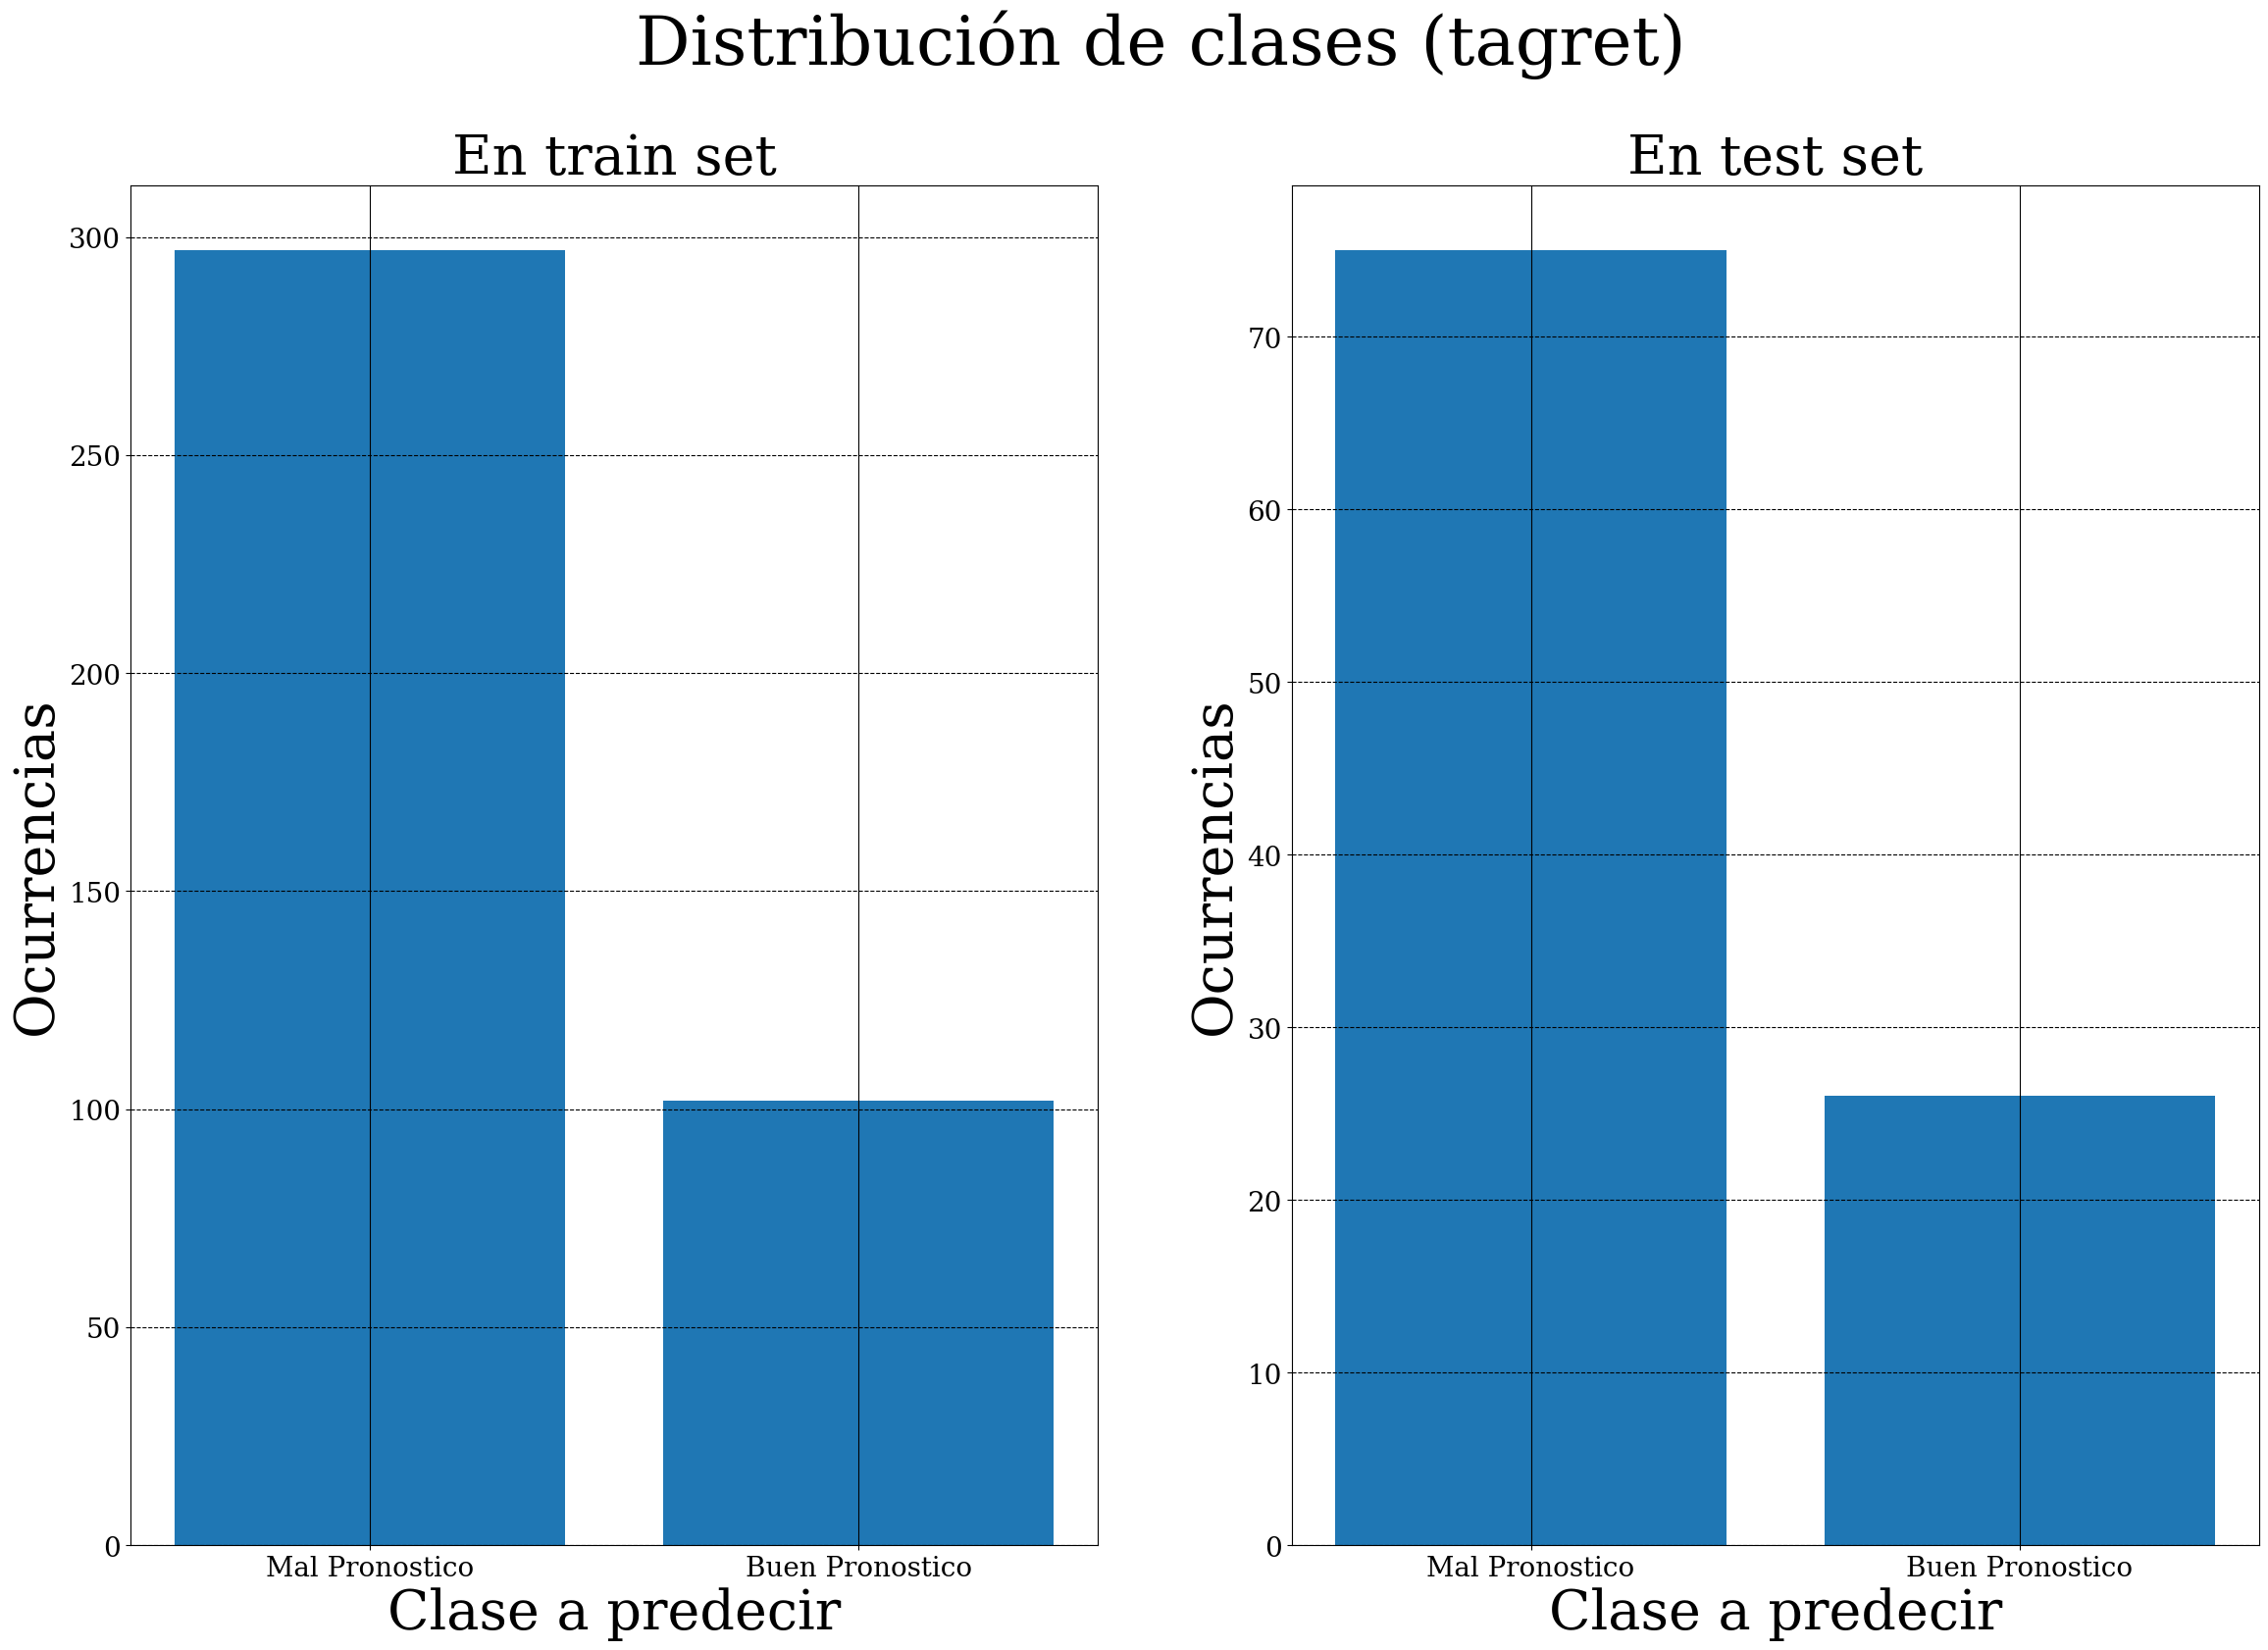

In [9]:
fig, ax = plt.subplots(1, 2)

plt.suptitle('Distribución de clases (tagret)', size = 50)

ax[0].bar(count_target.keys(), count_target_train.values())
ax[0].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[0].set_ylabel("Ocurrencias")
ax[0].set_xlabel("Clase a predecir")
ax[0].grid(ls="--", axis="y")
ax[0].set_title("En train set")

count_target_test = test_set.groupby("target")[test_set.columns[0]].count().to_dict()

ax[1].bar(count_target.keys(), count_target_test.values())
ax[1].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[1].set_ylabel("Ocurrencias")
ax[1].set_xlabel("Clase a predecir")
ax[1].grid(ls="--", axis="y")
ax[1].set_title("En test set")

plt.show()

Finalmente separamos la parte de las features de la parte de las etiquetas

In [10]:
X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test, y_test = test_set.drop("target", axis=1), test_set["target"]

## Ejercicio 2

### 2.1: Árbol sencillo

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, auc

Entrenemos un arbol de profundidad 3 y veamos rapidamente como dan las metricas

In [12]:
tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X=X_train, y=y_train)
y_pred_train = tree.predict(X_train)
y_probas_train = tree.predict_proba(X_train)

y_pred = tree.predict(X_test)
y_probas = tree.predict_proba(X_test)

print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Precision (Train): {precision_score(y_train, y_pred_train):.3f}")
print(f"Recall (Train): {recall_score(y_train, y_pred_train):.3f}")
print(f"ROC AUC (Train): {roc_auc_score(y_train, y_probas_train[:, 1]):.3f}")
print()
print(f"Accuracy (Test): {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (Test): {precision_score(y_test, y_pred):.3f}")
print(f"Recall (Test): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (Test): {roc_auc_score(y_test, y_probas[:, 1]):.3f}")

Accuracy (Train): 0.832
Precision (Train): 0.843
Recall (Train): 0.422
ROC AUC (Train): 0.726

Accuracy (Test): 0.733
Precision (Test): 0.474
Recall (Test): 0.346
ROC AUC (Test): 0.596


Si le sacamos las features poco importantes

In [13]:
important_features = list(scores.keys())[:25]

tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X=X_train[important_features], y=y_train)
y_pred_train = tree.predict(X_train[important_features])
y_probas_train = tree.predict_proba(X_train[important_features])

y_pred = tree.predict(X_test[important_features])
y_probas = tree.predict_proba(X_test[important_features])

print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Precision (Train): {precision_score(y_train, y_pred_train):.3f}")
print(f"Recall (Train): {recall_score(y_train, y_pred_train):.3f}")
print(f"ROC AUC (Train): {roc_auc_score(y_train, y_probas_train[:, 1]):.3f}")
print()
print(f"Accuracy (Test): {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (Test): {precision_score(y_test, y_pred):.3f}")
print(f"Recall (Test): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (Test): {roc_auc_score(y_test, y_probas[:, 1]):.3f}")

Accuracy (Train): 0.830
Precision (Train): 0.870
Recall (Train): 0.392
ROC AUC (Train): 0.702

Accuracy (Test): 0.703
Precision (Test): 0.417
Recall (Test): 0.385
ROC AUC (Test): 0.594


### 2.2: K-fold cross Validation

_versión facu_

In [36]:
from typing import Dict, Any

def auprc(y_true: np.ndarray, pred_probas: np.ndarray):
    """
    Calcular Area Under Precision Recall Curve (AUPRC).
    """

    precision, recall, _ = precision_recall_curve(y_true, pred_probas)
    return auc(recall, precision)


def cross_val(X_train: pd.DataFrame,
              y_train: pd.Series,
              model,
              params: Dict[str, Any],
              cv: int = 5):
    """
    Implementar cross validation de K folds para un modelo sin utilizar Scikit Learn.

    Args:
        X_train (pd.DataFrame): Features de entrenamiento.
        y_train (pd.Series): Target de entrenamiento.
        model: El modelo que se va a entrenar.
        params (Dict[str, Any]): Parámetros del modelo.
        cv (int): Número de folds para cross-validation.

    Returns:
        List[float]: Lista de scores para cada fold.
    """

    # Convertir a numpy arrays para facilidad de uso
    X = X_train.values
    y = y_train.values

    # Dividir los datos en K folds
    fold_size = len(X) // cv
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    scores = []

    for i in range(cv):

        # Crear índices para el fold de validación y de entrenamiento
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train_fold = X[train_indices]
        y_train_fold = y[train_indices]
        X_val_fold = X[val_indices]
        y_val_fold = y[val_indices]

        # Instanciar el modelo con los parámetros dados
        model_instance = model(**params)

        # Entrenar el modelo en el fold de entrenamiento
        model_instance.fit(X_train_fold, y_train_fold)

        # Calcular predicciones del modelo para el subset de entrenamiento
        y_train_fold_probas = model_instance.predict_proba(X_train_fold)[:, 1]
        y_train_fold_pred = model_instance.predict(X_train_fold)

        # Calcular predicciones del modelo para el subset de validación
        y_val_fold_probas = model_instance.predict_proba(X_val_fold)[:, 1]
        y_val_fold_pred = model_instance.predict(X_val_fold)

        # Calcular accuracies
        train_accuracy = accuracy_score(y_train_fold, y_train_fold_pred)
        val_accuracy = accuracy_score(y_val_fold, y_val_fold_pred)

        # Calcular AUC ROC
        train_rocauc = roc_auc_score(y_train_fold, y_train_fold_probas)
        val_rocauc = roc_auc_score(y_val_fold, y_val_fold_probas)

        # Calcular AU PRC
        train_auprc = auprc(y_train_fold, y_train_fold_probas)
        val_auprc = auprc(y_val_fold, y_val_fold_probas)

        # Guardar todas las métricas obtenidas
        score = {

            "Fold": i + 1,

            "Train Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy,

            "Train ROC AUC": train_rocauc,
            "Validation ROC AUC": val_rocauc,

            "Train AUPRC": train_auprc,
            "Validation AUPRC": val_auprc,
        }

        scores.append(score)

    return scores

results = cross_val(X_train, y_train, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5)
results = pd.DataFrame(results)

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"

results = pd.concat([results, mean_results]).reset_index(drop=True)

display(results)

,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.86250,0.708861,0.854481,0.622368,0.763196,0.336239
1,2,0.84375,0.620253,0.757019,0.545455,0.695489,0.337158
2,3,0.84375,0.759494,0.850948,0.671491,0.759437,0.582420
3,4,0.85000,0.734177,0.811516,0.550546,0.772451,0.338068
4,5,0.84375,0.721519,0.838287,0.596186,0.759540,0.400436
5,Promedio,0.84875,0.708861,0.822450,0.597209,0.750023,0.398864


### 2.2: K-fold cross Validation

_versión trini_

* calculo sobre todo el dataset --> no solo x train

(estas dos cosas tal vez son condicionales)
* verifico que haya una proporción / cociente igual en cada k-fold de casos de mal pronstico y buen pronostico (esto así tal vez es muy restrictivo pero es razonable pensar en que no haya un desbalance muy grande)
* agrego condición de quedarme con las n primeras features que mejor correlacionan

(cómo era el score global ?)

In [39]:
def stratified_sampling_kfolds(
        df: pd.DataFrame,
        num_folds: int = 5,
    ) -> list:

    """
    Obtener los indices que definen k-folds del dataset preservando el porcentaje de 0 y 1 del target
    Caso de target binario
    """

    #lista con indices de k-folds
    indices = []

    #indices con valores negativos y positivos del target
    pos_idx = df.index[df['target'] == 1].tolist()
    neg_idx = df.index[df['target'] == 0].tolist()

    np.random.seed(42)
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    #divido a los indices positvos y negativos según la cantidad de folds 

    #valores enteros
    num_pos = len(pos_idx)//num_folds
    num_neg = len(neg_idx)//num_folds

    #restos
    resto_pos = len(pos_idx)%num_folds
    resto_neg = len(neg_idx)%num_folds

    #agrego fracciones de indices según la cantidad de folds a la lista indices
    for i in range(num_folds):
        indices.append(np.concatenate([pos_idx[i*(num_pos): (i + 1)*(num_pos)], neg_idx[i*(num_neg): (i + 1)*(num_neg)]]))
    
    #agrego a la lista los últimos valores que me faltaron (num de indices no dividibles por num_folds)
    for i in range(resto_pos):
        indices[i] = np.append(indices[i], pos_idx[-(i + 1)])

    for i in range(resto_pos, resto_neg + resto_pos):
        indices[i] = np.append(indices[i], neg_idx[-(i + 1)])

    return np.concatenate([indices]).ravel()

In [41]:
from typing import Dict, Any

def auprc(y_true: np.ndarray, pred_probas: np.ndarray):
    """
    Calcular Area Under Precision Recall Curve (AUPRC).
    """

    precision, recall, _ = precision_recall_curve(y_true, pred_probas)
    return auc(recall, precision)


def cross_val(dataset: pd.DataFrame,
              model,
              params: Dict[str, Any],
              cv: int = 5,
              relevant_features: bool = False,
              num_features: int = 25,
              preserve_proportion: bool = True):
    """
    Implementar cross validation de K folds para un modelo sin utilizar Scikit Learn.

    Args:
        Datset (pd.DataFrame): Dataset de entrenamiento (features + target).
        model: El modelo que se va a entrenar.
        params (Dict[str, Any]): Parámetros del modelo.
        cv (int): Número de folds para cross-validation.
        relevant_features (bool): Quedarme con las features que más correlacionan en cada k-fold.
        num_features (int): Cantidad de features con las que me quedo.
        preserve_proportion (bool): preservar la cantidad de positivos y negativos en cada k-fold.

    Returns:
        List[float]: Lista de scores para cada fold.
    """
    np.random.seed(42)

    #Separo el target de las features
    X = dataset.drop('target', axis = 1)
    y = dataset['target']

    # Dividir los datos en K folds --> Según si preservo las proporciones del target en cada k-fold o no
    if preserve_proportion:
        indices = stratified_sampling_kfolds(dataset, num_folds=cv)
    else:
        indices = np.arange(len(dataset))
        np.random.shuffle(indices)

    scores = []
    fold_size = len(df) // cv


    for i in range(cv):

        #selecciono los índices de validación (conjunto D_i) y de training (D_j / j =! i)
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train_fold = X.iloc[train_indices]
        y_train_fold = y.iloc[train_indices]
        X_val_fold = X.iloc[val_indices]
        y_val_fold = y.iloc[val_indices]

        # Me quedo con features que tienen alta correlación con el target para simplificar el modelo 
        if relevant_features:
            corr = [(c, abs(pointbiserialr(y_train_fold, X_train_fold[c]).statistic)) for c in X_train_fold.columns if c != "target"]
            corr = sorted(corr, key=lambda x: x[1], reverse=True)
            corr = dict(corr)
            important_features = list(corr.keys())[:num_features]

            X_train_fold = X_train_fold[important_features]
            X_val_fold = X_val_fold[important_features]

        # Instanciar el modelo con los parámetros dados
        model_instance = model(**params)

        # Entrenar el modelo en el fold de entrenamiento
        model_instance.fit(X_train_fold, y_train_fold)

        # Calcular predicciones del modelo para el subset de entrenamiento
        y_train_fold_probas = model_instance.predict_proba(X_train_fold)[:, 1]
        y_train_fold_pred = model_instance.predict(X_train_fold)

        # Calcular predicciones del modelo para el subset de validación
        y_val_fold_probas = model_instance.predict_proba(X_val_fold)[:, 1]
        y_val_fold_pred = model_instance.predict(X_val_fold)

        # Calcular accuracies
        train_accuracy = accuracy_score(y_train_fold, y_train_fold_pred)
        val_accuracy = accuracy_score(y_val_fold, y_val_fold_pred)

        # Calcular AUC ROC
        train_rocauc = roc_auc_score(y_train_fold, y_train_fold_probas)
        val_rocauc = roc_auc_score(y_val_fold, y_val_fold_probas)

        # Calcular AU PRC
        train_auprc = auprc(y_train_fold, y_train_fold_probas)
        val_auprc = auprc(y_val_fold, y_val_fold_probas)

        # Guardar todas las métricas obtenidas
        score = {

            "Fold": i + 1,

            "Train Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy,

            "Train ROC AUC": train_rocauc,
            "Validation ROC AUC": val_rocauc,

            "Train AUPRC": train_auprc,
            "Validation AUPRC": val_auprc,
        }

        scores.append(score)

    return scores

In [33]:
print('Resultados preservando la proporción\n')

print('Con features más relevantes')
results = cross_val(df, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5, relevant_features=True, preserve_proportion=True)
results = pd.DataFrame(results)

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results = pd.concat([results, mean_results]).reset_index(drop=True)
display(results)

print('Con TODAS las features')
results = cross_val(df, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5, relevant_features=False, preserve_proportion=True)
results = pd.DataFrame(results)

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results = pd.concat([results, mean_results]).reset_index(drop=True)
display(results)


Resultados preservando la proporción

Con features más relevantes


,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.8125,0.760,0.835949,0.626819,0.699655,0.463716
1,2,0.8450,0.760,0.817114,0.741684,0.710915,0.513891
2,3,0.8450,0.770,0.821342,0.744802,0.714225,0.454132
3,4,0.8375,0.760,0.830538,0.673600,0.734459,0.505324
4,5,0.8050,0.780,0.806724,0.711200,0.667002,0.549078
5,Promedio,0.8290,0.766,0.822333,0.699621,0.705251,0.497228


Con TODAS las features


,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.8275,0.770,0.847825,0.655925,0.727932,0.492396
1,2,0.8575,0.770,0.826984,0.713098,0.748883,0.529165
2,3,0.8600,0.760,0.824335,0.722713,0.737257,0.459234
3,4,0.8575,0.750,0.833709,0.509333,0.759188,0.374155
4,5,0.8375,0.760,0.821434,0.676800,0.651993,0.338618
5,Promedio,0.8480,0.762,0.830858,0.655574,0.725050,0.438713


Comparado con los resultados de Facu mejoran bastante los scores de validación (promedio), mismo quedandonos con los features más relevantes

In [35]:
print('Resultados sin preservar la proporción\n')

print('Con features más relevantes')
results = cross_val(df, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5, relevant_features=True, preserve_proportion=False)
results = pd.DataFrame(results)

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results = pd.concat([results, mean_results]).reset_index(drop=True)
display(results)

print('Con TODAS las features')
results = cross_val(df, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5, relevant_features=False, preserve_proportion=False)
results = pd.DataFrame(results)

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results = pd.concat([results, mean_results]).reset_index(drop=True)
display(results)


Resultados sin preservar la proporción

Con features más relevantes


,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.8000,0.820,0.838914,0.667316,0.702819,0.408350
1,2,0.8400,0.750,0.803090,0.739726,0.683207,0.569474
2,3,0.8100,0.740,0.769870,0.589344,0.710943,0.247706
3,4,0.8675,0.740,0.831072,0.719669,0.730013,0.569406
4,5,0.8500,0.730,0.840393,0.699158,0.717878,0.553132
5,Promedio,0.8335,0.756,0.816668,0.683043,0.708972,0.469614


Con TODAS las features


,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.8325,0.74,0.838157,0.668616,0.719008,0.253164
1,2,0.8450,0.74,0.814067,0.740741,0.722146,0.539110
2,3,0.8150,0.73,0.768041,0.544185,0.716909,0.222357
3,4,0.8675,0.71,0.833864,0.695542,0.751587,0.456462
4,5,0.8600,0.73,0.840683,0.697055,0.737244,0.555623
5,Promedio,0.8440,0.73,0.818962,0.669228,0.729379,0.405343


Nos damos cuenta que en realidad mejora tambien cuando no preservamos la proporción de 0s y 1s --> esto es (probablemente) porque facu usó solo X_train. Sim embargo el otro caso mejora (generalmente, aunque es sutil, del orden de un 5% cada score)

### 2.3: Busqueda de hiperparámetros:
_versión facu_


In [37]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "max_depth": [3, 5, None],
    "criterion": ["gini", "entropy"]
}

param_grid = ParameterGrid(param_grid)

hyperparams_search_results = []

# Iteramos sobre cada combinacion de hiperparámetros
for params in param_grid:

    # Hacemos cross validation para 5 folds
    results = cross_val(X_train, y_train, DecisionTreeClassifier, params, cv=5)

    # Guardamos los hiperparámetros y los resultados promedio para cada métrica
    results = {**params, **pd.DataFrame(results).mean().to_dict()}

    hyperparams_search_results.append(results)

# Convertir a DataFrame
hyperparams_search_results = pd.DataFrame(hyperparams_search_results)
hyperparams_search_results = hyperparams_search_results.drop("Fold", axis=1)

# Redondear a 3 cifras
metrics = ["Train Accuracy", "Validation Accuracy",
           "Train ROC AUC", "Validation ROC AUC",
           "Train AUPRC", "Validation AUPRC"]
hyperparams_search_results[metrics] = hyperparams_search_results[metrics].round(3)

hyperparams_search_results

,criterion,max_depth,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,gini,3.0,0.838,0.722,0.798,0.565,0.739,0.363
1,gini,5.0,0.909,0.668,0.891,0.523,0.878,0.356
2,gini,NaN,1.000,0.668,1.000,0.570,1.000,0.442
3,entropy,3.0,0.831,0.716,0.830,0.596,0.727,0.373
4,entropy,5.0,0.894,0.676,0.959,0.587,0.906,0.401
5,entropy,NaN,1.000,0.638,1.000,0.548,1.000,0.413


Overfit a medida que aumentamos la profundidad... Ver como caen las tres métricas en el validation set a medida que aumentamos la profundidad del arbol, con cualquiera de los dos criterios.

### 2.3: Busqueda de hiperparámetros:
_versión trini_
* Exploro caso preservando % de positivos y negativos

In [42]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "max_depth": [3, 5, None],
    "criterion": ["gini", "entropy"]
}

param_grid = ParameterGrid(param_grid)

hyperparams_search_results = []

# Iteramos sobre cada combinacion de hiperparámetros
for params in param_grid:

    # Hacemos cross validation para 5 folds
    #results = cross_val(X_train, y_train, DecisionTreeClassifier, params, cv=5)
    results = cross_val(df, DecisionTreeClassifier, params, cv=5, relevant_features=False, preserve_proportion=True)

    # Guardamos los hiperparámetros y los resultados promedio para cada métrica
    results = {**params, **pd.DataFrame(results).mean().to_dict()}

    hyperparams_search_results.append(results)

# Convertir a DataFrame
hyperparams_search_results = pd.DataFrame(hyperparams_search_results)
hyperparams_search_results = hyperparams_search_results.drop("Fold", axis=1)

# Redondear a 3 cifras
metrics = ["Train Accuracy", "Validation Accuracy",
           "Train ROC AUC", "Validation ROC AUC",
           "Train AUPRC", "Validation AUPRC"]
hyperparams_search_results[metrics] = hyperparams_search_results[metrics].round(3)

hyperparams_search_results

,criterion,max_depth,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,gini,3.0,0.848,0.762,0.831,0.656,0.725,0.439
1,gini,5.0,0.941,0.728,0.939,0.568,0.923,0.442
2,gini,NaN,1.000,0.710,1.000,0.617,1.000,0.502
3,entropy,3.0,0.833,0.756,0.834,0.650,0.705,0.442
4,entropy,5.0,0.914,0.730,0.965,0.657,0.925,0.480
5,entropy,NaN,1.000,0.708,1.000,0.609,1.000,0.489


Lo mismo que facu, pero cuando preservamos la proporción aumentan las accuracys de validación en general.

## Ejercicio 3

## 3.1

In [60]:
from sklearn.model_selection import RandomizedSearchCV
import warnings

def experiment(df, model,
               param_grid):
    """
    Realizar busqueda de hiperparámetros para un modelo
    con su grilla dada. Se realiza Cross Validation para
    5 folds con métrica ROC AUC.
    """
    with warnings.catch_warnings(record=True) as caught_warnings:
        random_search_cv = RandomizedSearchCV(estimator=model(),
                                param_distributions=param_grid,
                                cv=5,
                                n_jobs=-1,
                                scoring="roc_auc",
                                verbose=2)

        X = df.drop('target', axis = 1)
        y = df['target']

        random_search_cv.fit(X, y)

        best_model = random_search_cv.best_estimator_
        best_params = random_search_cv.best_params_

        for warning in caught_warnings:
            if isinstance(warning.message, UserWarning):
                print("Warning caught!")
                print("Warning message:", warning.message)
                print("Parameters at that moment:", param_grid)

    return best_model, best_params


def get_scoring(model, params):

    # Realizar predicciones sobre el set de testeo y training
    train_predictions = model.predict(X_train)
    train_probas = model.predict_proba(X_train)[:, 1]
    test_predictions = model.predict(X_test)
    test_probas = model.predict_proba(X_test)[:, 1]

    # Calcular métricas para el set de entrenamiento
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_rocauc = roc_auc_score(y_train, train_probas)
    train_auprc = auprc(y_train, train_probas)

    # Calcular métricas sobre el set de testeo
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_rocauc = roc_auc_score(y_test, test_probas)
    test_auprc = auprc(y_test, test_probas)

    score = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,

        "Train ROC AUC": train_rocauc,
        "Test ROC AUC": test_rocauc,

        "Train AUPRC": train_auprc,
        "Test AUPRC": test_auprc,
    }

    score["name"] = model.__class__.__name__
    score["params"] = model_params

    return score

In [54]:
decision_tree_param_grid = {
    "max_depth": [3, 5, None],
    "criterion": ["gini", "entropy"],
    "max_features": [None, "sqrt", "log2"],
    "min_impurity_decrease": [0.5, 0]
}


best_model, model_params = experiment(df, DecisionTreeClassifier, decision_tree_param_grid)
print(f'Best model params: {model_params}')

score = get_scoring(best_model, model_params)
score

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model params: {'min_impurity_decrease': 0, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}


{'Train Accuracy': 0.8220551378446115,
 'Test Accuracy': 0.8514851485148515,
 'Train ROC AUC': 0.8105070310952665,
 'Test ROC AUC': 0.8207692307692308,
 'Train AUPRC': 0.698979324886515,
 'Test AUPRC': 0.7489754687570938,
 'name': 'DecisionTreeClassifier',
 'params': {'min_impurity_decrease': 0,
  'max_features': 'sqrt',
  'max_depth': 5,
  'criterion': 'entropy'}}

In [63]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {
    "n_neighbors": [5],
    "weights": ["uniform", "distance"],
    "algorithm": ['kd_tree', "ball_tree", "brute"],
    "p": [2]
}

best_model, model_params = experiment(df, KNeighborsClassifier, knn_param_grid)
score = get_scoring(best_model, model_params)

score

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Warning caught!
Warning message: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
Parameters at that moment: {'n_neighbors': [5], 'weights': ['uniform', 'distance'], 'algorithm': ['kd_tree', 'ball_tree', 'brute'], 'p': [2]}
Warning caught!
Warning message: One or more of the test scores are non-finite: [0.79817691 0.80872305 0.79817691 0.80872305        nan 0.80872305]
Parameters at that moment: {'n_neighbors': [5], 'weights': ['uniform', 'distance'], 'algorithm': ['kd_tree', 'ball_tree', 'brute'], 'p': [2]}


{'Train Accuracy': 1.0,
 'Test Accuracy': 1.0,
 'Train ROC AUC': 1.0,
 'Test ROC AUC': 1.0,
 'Train AUPRC': 1.0,
 'Test AUPRC': 1.0,
 'name': 'KNeighborsClassifier',
 'params': {'weights': 'distance',
  'p': 2,
  'n_neighbors': 5,
  'algorithm': 'kd_tree'}}